<a href="https://colab.research.google.com/github/KU-Gen-AI-2567/Autoencoder-demo/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder - 01418496 (หมู่เรียน 200)

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import kagglehub
import shutil
import os
tf.__version__

'2.17.1'

In [4]:
import numpy as np
from PIL import Image

### Setting to execute on Processor (GPU or CPU)

In [5]:
gpus = tf.config.list_physical_devices("GPU")
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("Execute on GPU")
else:
    print("Execute on CPU")

Execute on GPU


### Download Dataset

In [6]:
# Download the dataset folder in latest version
if not "dataset" in os.listdir("."):
    path = kagglehub.dataset_download("tongpython/cat-and-dog/version/1")
    print("Path to dataset files:", path)
    shutil.move(path, "./dataset")
    print("Download Dataset Complete")
else:
    print("Download Dataset Already")

Download Dataset Already


## Prepossessing


In [7]:
dataset_path = "./dataset"
for dirpath, dirnames, filenames in os.walk(dataset_path):
    print(f"Path: {dirpath}, Subdirectories: {dirnames}, Files: {len(filenames)}")

Path: ./dataset, Subdirectories: ['training_set', 'test_set'], Files: 0
Path: ./dataset/training_set, Subdirectories: ['training_set'], Files: 0
Path: ./dataset/training_set/training_set, Subdirectories: ['dogs', 'cats'], Files: 0
Path: ./dataset/training_set/training_set/dogs, Subdirectories: [], Files: 4006
Path: ./dataset/training_set/training_set/cats, Subdirectories: [], Files: 4001
Path: ./dataset/test_set, Subdirectories: ['test_set'], Files: 0
Path: ./dataset/test_set/test_set, Subdirectories: ['dogs', 'cats'], Files: 0
Path: ./dataset/test_set/test_set/dogs, Subdirectories: [], Files: 1013
Path: ./dataset/test_set/test_set/cats, Subdirectories: [], Files: 1012


In [8]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0  # Normalize pixel values to [0, 1]
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.0)
    return imgs

def to_image(img):
    img = np.squeeze(img)
    return Image.fromarray(np.uint8(img * 255))

In [9]:
def dataset_to_numpy_and_preprocess(dataset):
    images, labels = [], []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    imgs = np.concatenate(images)
    lbls = np.concatenate(labels)
    return preprocess(imgs), lbls

In [10]:
train_dir = "./dataset/training_set/training_set"
test_dir = "./dataset/test_set/test_set"

In [11]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(100, 100),  # Resize images
    batch_size=32,
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(100, 100),
    batch_size=32,
)

X_train, y_train = dataset_to_numpy_and_preprocess(train_dataset)
X_test, y_test = dataset_to_numpy_and_preprocess(test_dataset)

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


In [12]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
SHAPE = X_train.shape[1:]
print(f"Shape {SHAPE}")

X_train shape: (8005, 104, 104, 3)
y_train shape: (8005,)
X_test shape: (2023, 104, 104, 3)
y_test shape: (2023,)
Shape (104, 104, 3)


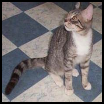

In [13]:
to_image(X_train[8000])

### Create Model by using OOP

In [14]:
from tensorflow.keras import Model, layers, losses

class Autoencoder(Model):
  def __init__(self, shape):
    super(Autoencoder, self).__init__()
    self.shape = shape

    self.encoder = tf.keras.Sequential([
      layers.Input(shape=SHAPE),
      layers.Conv2D(filters=64, kernel_size=(10, 10), padding='same', activation='relu'),
      layers.Conv2D(filters=32, kernel_size=(10, 10), padding='same', activation='relu'),
    ])


    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(filters=32, kernel_size=(10, 10), padding='same', activation='relu'),
      layers.Conv2DTranspose(filters=64, kernel_size=(10, 10), padding='same', activation='relu'),
      layers.Conv2D(filters=SHAPE[-1], kernel_size=(10, 10), padding='same', activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [15]:
autoencoder = Autoencoder(SHAPE)

In [16]:
autoencoder.encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 104, 104, 64)        │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 104, 104, 32)        │         204,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 224,096 (875.38 KB)

 Trainable params: 224,096 (875.38 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
autoencoder.decoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose (Conv2DTranspose)   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
autoencoder.compile(optimizer="adam", loss=losses.MeanSquaredError())

In [19]:
autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_test, X_test))

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 94s 284ms/step - loss: 0.0460 - val_loss: 0.0062
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 110s 245ms/step - loss: 0.0061 - val_loss: 0.0042
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 78s 230ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 85s 245ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 244ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 61s 242ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 79s 231ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 230ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 9/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 85s 244ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 10/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 57s 228ms/step - loss: 0.0018 - val_loss: 0.0016


In [20]:
autoencoder.encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 104, 104, 64)        │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 104, 104, 32)        │         204,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 224,096 (875.38 KB)

 Trainable params: 224,096 (875.38 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
autoencoder.decoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose (Conv2DTranspose)   │ (None, 104, 104, 32)        │         102,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 104, 104, 64)        │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 104, 104, 3)         │          19,203 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 326,499 (1.25 MB)

 Trainable params: 326,499 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
encoded_imgs = autoencoder.encoder(X_test)
decoded_imgs = autoencoder.decoder(encoded_imgs)

ResourceExhaustedError: Exception encountered when calling Conv2D.call().

[1m{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[2023,64,104,104] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D][0m

Arguments received by Conv2D.call():
  • inputs=tf.Tensor(shape=(2023, 104, 104, 3), dtype=float32)

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i])
    plt.title("original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)